In [ ]:
#| default_exp process

# process

> Image processing submodule.

In [ ]:
#| hide 
# %pylab inline
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev import *

In [ ]:
#| exporti
import configparser
from fastcore.basics import patch
from os.path import expanduser
from ouscope.core import Telescope
from ouscope.solver import Solver

from IPython import display

import time
from datetime import datetime
import os
from requests import session
from bs4 import BeautifulSoup
from io import StringIO, BytesIO
from zipfile import ZipFile
from astropy.io import fits
from astropy.coordinates import SkyCoord, Longitude, Latitude
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import simple_norm
from astroquery.vizier import Vizier
from tqdm.auto import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.path import Path
import numpy as np
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from numpy import argsort
from sqlitedict import SqliteDict

from astropy.visualization import make_lupton_rgb

import astroalign as aa
from collections import namedtuple
from ouscope.vs import get_VS_sequence

In [ ]:
#| hide
#| exporti
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
#| login
solver = Solver()

In [ ]:
#| login
OSO=Telescope(config='~/.config/telescope.ini')

In [ ]:
Job = namedtuple('Job', 'jid rid done')

In [ ]:
DB = SqliteDict('telescope.sqlite', autocommit=True)
VSdb = SqliteDict('vstars.sqlite', autocommit=True)

In [ ]:
if not ('done' in DB):
    DB['done'] = set()
if not ('problematic' in DB):
    DB['problematic'] = set()
done = DB['done']
problematic = DB['problematic']

In [ ]:
# VSdb['BE Vul']

In [ ]:
for vs in VSdb.items():
    if 'seq' in vs[1] and vs[1]['seq'] and vs[1]['seq'][0] and vs[1]['seq'][1]:
        print(vs[0], len(vs[1]['jobs']) )
    else :
        # print(vs)
        pass

In [ ]:
#| exporti
def make_color_image(layers, black=1.0, Q=5, stretch=200, mults=(0.95, 1.0, 1.0), order='BVR'):

    seq = argsort(list(order))
    b, r, g = (m*layers[l] for m,l in zip(mults,seq))
    # print([order[i] for i in seq])
    
    try :
        r_r, r_f = aa.register(r, g, detection_sigma=10)
    except TypeError:
        r_r = r
        
    try :
        b_r, b_f = aa.register(b, g, detection_sigma=10)
    except TypeError:
        b_r = b
        
    minlev = np.array([sigma_clipped_stats(l, sigma=3.0)[1] for l in (r,g,b)])
    return make_lupton_rgb(0.9*r_r, g, b_r, minimum=black*minlev, Q=Q, stretch=stretch)

In [ ]:
#| export
verts = [
    (0, 0.5),
    (0.3, 0.5),
    (0.7, 0.5),
    (1, 0.5),
]
verts = verts + [(y, x) for x, y in verts]
verts = [(y-0.5, x-0.5) for x, y in verts]
codes = 4*[Path.MOVETO, Path.LINETO]
marker = Path(verts, codes)

In [ ]:
#| export
def plot_sequence(vs):
    if vs in VSdb:
        seq = VSdb[vs]['seq']
        if not seq[0]:
            return
    ax = plt.gca()
    ax.text(0, 0, seq[0], color='C1')
    for s in seq[1]:
        print(s)
        dx = 20/3600
        ax.plot(s[3], s[5], marker=marker, lw=1, color='C2', ms=30, transform=ax.get_transform('world'))
        ax.text(s[3]+dx, s[5]-dx, s[1], color='white', transform=ax.get_transform('world'))

In [ ]:
#| export
def process_job(jid, reprocess=False, cls=True, layer=None):
    job = OSO.get_job(jid)
    ctime = job['completion']
    req = OSO.get_request(int(job['rid'].split()[0]))
    target = req['name'].lstrip().rstrip()
    print(f'jid {jid}: ({target})')
    print(f'{" ".join(ctime)}')
    z = OSO.get_obs(job, cube=False, verbose=False)    
    hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]
    if layer is not None:
        hdul=[hdul[layer]]
    # hdul = fits.open(OSO.get_obs(job, cube=True, verbose=False))
    print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')
    if not reprocess and jid in DB :
        print('Done')
        if cls:
            display.clear_output(wait=True);
        return
    hi = min(1, len(hdul)-1)
    # hi = 0
    for hdu in hdul:
        wcs_head = solver.solve(hdu, tout=30)
        if wcs_head:
            break
    if not wcs_head:
        print('Cannot solve image')
        OSO.get_obs(job, cube=True, verbose=False)
        data = hdul[hi].data[:-32,:-32]
        plt.imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
        plt.show();
        return
    w = WCS(wcs_head)
    box = w.calc_footprint()
    c = box.mean(axis=0)
    s = box.max(axis=0) - box.min(axis=0)
    result = Vizier.query_region(catalog='B/gcvs', 
                                 coordinates=SkyCoord(*c, unit='deg', frame='fk5'), 
                                 width=f'{s[0]}deg', height=f'{s[1]}deg')
#     for g in result:
#         for n, o in enumerate(g):
#             if 'Name' in o.keys():
#                 name = o['Name']
#             elif 'GCVS' in o.keys():
#                 name = ' '.join(o['GCVS'].split())
#             elif 'NSV' in o.keys():
#                 name = f'NSV_{o["NSV"]}'

#             print(f'{name:12} {o["magMax"]:6.2f}', o)
    ax = plt.subplot(projection=w)
    plt.grid(color='white', ls='solid')
    for g in result:
        print(g)
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'
            else :
                name = f'VS_{n}'
            if name.startswith('V0'):
                name = 'V'+name[2:]
            if name in VSdb:
                jobl = VSdb[name]
            else :
                jobl = {}
                jobl['jobs']=set()
            jobl['jobs'] |= {jid}
            VSdb[name]=jobl
            try :
                frame='icrs'
                try :
                    radec = SkyCoord(o['RAJ2000'] + o['DEJ2000'], 
                                     frame=frame, unit=(u.hourangle, u.deg))
                except ValueError:
                    radec = SkyCoord(o['RAJ2000'], o['DEJ2000'], 
                                     frame=frame, unit=(u.deg, u.deg))                    
            except KeyError:
                    radec =  SkyCoord(o['_RA.icrs'] + o['_DE.icrs'], 
                                     frame='icrs', unit=(u.hourangle, u.deg))
                    frame='icrs'
#                     radec =  SkyCoord(o['RAB1950'] + o['DEB1950'], 
#                                      frame='fk4', unit=(u.hourangle, u.deg))
            ax.plot(radec.ra.deg, radec.dec.deg, marker=marker, color='C1', ms=30,
                    transform=ax.get_transform('world'), )#edgecolor='yellow', facecolor='none')
            ax.text(radec.ra.deg+0.012, radec.dec.deg-0.012, f'{name} ({o["magMax"]:.1f})', 
                    transform=ax.get_transform('world'), color='white')
            if name.lstrip().rstrip().lower() == target.lower():
                plot_sequence(target)
                
    if cls :
        display.clear_output(wait=True)
        print(f'jid {jid}: ({target})')
        print(f'{" ".join(ctime)}')
        print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')

    try :
        if len(hdul)==3:
            plt.imshow(make_color_image([hdu.data[:-32,:-32] for hdu in hdul], order=tuple(hdu.header["FILTER"] for hdu in hdul)))
        else :
            data = hdul[hi].data[:-32,:-32]
            plt.imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    except aa.MaxIterError:
        data = hdul[hi].data[:-32,:-32]
        plt.imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    DB[jid]=Job(jid, [int(rid[1:]) for rid in job['rid'].split()], True)
    plt.show()
    display.display(plt.gcf());    

In [ ]:
#| export
def analyse_job(jid, rid=None, reprocess=False):
    job = OSO.get_job(jid)
    ctime = job['completion']
    if rid is None:
        rid=int(job['rid'].split()[0])
    req = OSO.get_request(rid)
    target = req['name'].lstrip().rstrip()
    print(f'J{jid}:R{rid} ({target}) {" ".join(ctime)}')
    z = OSO.get_obs(job, cube=False, verbose=False)
    hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]
    print(f'Filters: {" ".join(hdu.header["FILTER"] for hdu in hdul)}')
    if not reprocess and jid in DB:
        print('Done')
        return
    hi = min(1, len(hdul)-1)
    # hi = 0
    for hdu in hdul:
        wcs_head = solver.solve(hdu, tout=30)
        if wcs_head:
            break
    if not wcs_head:
        print('Cannot solve image')
        OSO.get_obs(job, cube=True, verbose=False)
        return
    w = WCS(wcs_head)
    box = w.calc_footprint()
    c = box.mean(axis=0)
    s = box.max(axis=0) - box.min(axis=0)
    result = Vizier.query_region(catalog='B/gcvs', 
                                 coordinates=SkyCoord(*c, unit='deg', frame='fk5'), 
                                 width=f'{s[0]}deg', height=f'{s[1]}deg')
    for g in result:
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'
            else :
                name = f'VS_{n}'
            if name.startswith('V0'):
                name = 'V'+name[2:]
            if name in VSdb:
                jobl = VSdb[name]
            else :
                jobl = {}
                jobl['jobs']=set()
                jobl['seq']=None
            try :
                jobl['jobs'] |= {jid}
            except TypeError:
                jobl['jobs'] = {jid}
            if not jobl['seq']:
                try :
                    seq = get_VS_sequence(name, 40, 16)
                except ConnectionError:
                    time.sleep(5)
                    seq = get_VS_sequence(name, 40, 16)
                if seq[0] and seq[1]:
                    jobl['seq']=seq
            VSdb[name]=jobl
            print(f'{name}', end=" ")
            if jobl["seq"] and jobl["seq"][0] and jobl["seq"][1]:
                print(f'seq:{jobl["seq"][0]} ({len(jobl["seq"][1])})')
            else :
                print()                      
    DB[jid]=Job(jid, [int(rid[1:]) for rid in job['rid'].split()], True)
    return True

In [ ]:
#| login
reqlst=OSO.get_user_requests(sort='completion')
print(f'Number of users requests: {len(reqlst)}')

complete = [rq for rq in sorted(reqlst, key=lambda r: int(r['requesttime']), reverse=True) 
                    if Telescope.REQUESTSTATUS_TEXTS[int(rq['status'])]=='Complete']
print('Completed:', len(complete))

Number of users requests: 1849
Completed: 1821


J422672:R771144 (LX Cyg) 11 November 2024 00:25:33 UTC
Filters: R V B
Solving for EEAD1B8F
solve-field -p -l 30 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 2 /tmp/field-solverje1asjpl/tmp5g2rwh0v.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X38910YH (41)
LX Cyg seq:X38910YI (44)
LY Cyg seq:X38910YJ (40)
V681 Cyg seq:X38910YK (32)
V682 Cyg seq:X38910YL (13)
V2173 Cyg seq:X38910YM (9)
V2657 Cyg seq:X38910YN (17)
NSV_13959 
NSV_25782 
jid 422672: (LX Cyg)
11 November 2024 00:25:33 UTC
Filters: ('R', 'V', 'B')
Getting EEAD1B8F from cache


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


   GCVS   n_GCVS   RAJ2000     DEJ2000   ...    SpType   Exists  VarName  Simbad
                                         ...                                    
--------- ------ ----------- ----------- ... ----------- ------ --------- ------
   LV Cyg      x 21 55 08.02 +48 13 48.2 ...          M7        LV    Cyg Simbad
   LX Cyg      * 21 55 57.07 +48 20 50.9 ... SC3e-S5,5e:        LX    Cyg Simbad
   LY Cyg      x 21 56 10.40 +48 04 13.3 ...          M5        LY    Cyg Simbad
V0681 Cyg      x 21 55 25.24 +48 29 24.8 ...                    V0681 Cyg Simbad
V0682 Cyg      x 21 56 23.65 +48 37 54.6 ...          M6        V0682 Cyg Simbad
V2173 Cyg      x 21 57 02.23 +48 40 06.8 ...                    V2173 Cyg Simbad
V2657 Cyg      x 21 53 38.07 +48 24 13.4 ...                    V2657 Cyg Simbad
['000-BCP-557', '75', '21:54:42.03', 328.67510986, '48:11:55.4', 48.19872284, '7.783 (0.080)', '7.501 (0.072)', '0.282 (0.108)', '—']
['000-BCP-564', '79', '21:54:52.56', 328.71899414, '48:3

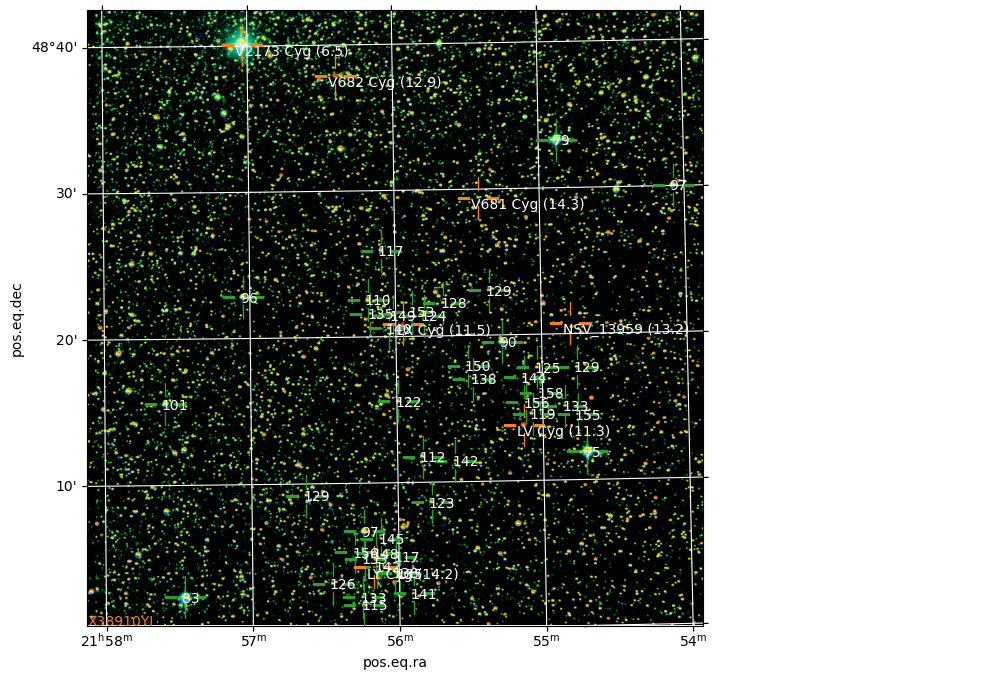

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

J422671:R771143 (EQ Lyr) 10 November 2024 20:24:07 UTC
Filters: R V B
Solving for 3371DF4E
solve-field -p -l 30 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 2 /tmp/field-solver7o6os7or/tmp_kdmm45h.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X38910YP (9)
V476 Lyr seq:X38910YQ (3)
V588 Lyr seq:X38910YR (8)
jid 422671: (EQ Lyr)
10 November 2024 20:24:07 UTC
Filters: ('R', 'V', 'B')
Getting 3371DF4E from cache


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


   GCVS   n_GCVS   RAJ2000     DEJ2000   ... SpType Exists  VarName  Simbad
                                         ...                               
--------- ------ ----------- ----------- ... ------ ------ --------- ------
   EQ Lyr      x 19 19 02.63 +41 06 34.5 ...               EQ    Lyr Simbad
V0476 Lyr      x 19 19 49.83 +40 47 08.2 ...               V0476 Lyr Simbad
V0588 Lyr      x 19 19 55.00 +40 52 40.0 ...               V0588 Lyr Simbad
['000-BKK-100', '107', '19:19:08.67', 289.78613281, '41:06:39.6', 41.11100006, '12.415 (0.079)', '10.675 (0.053)', '1.740 (0.095)', '9.820 (0.106)']
['000-BKK-101', '110', '19:18:28.61', 289.61920166, '41:10:29.4', 41.17483521, '11.797 (0.032)', '10.988 (0.017)', '0.809 (0.036)', '10.571 (0.060)']
['000-BKK-102', '114', '19:19:19.21', 289.83004761, '41:12:18.0', 41.20500183, '12.042 (0.036)', '11.412 (0.024)', '0.630 (0.043)', '11.032 (0.027)']
['000-BKK-103', '118', '19:19:06.51', 289.77713013, '41:16:06.3', 41.26841736, '12.359 (0.050)'

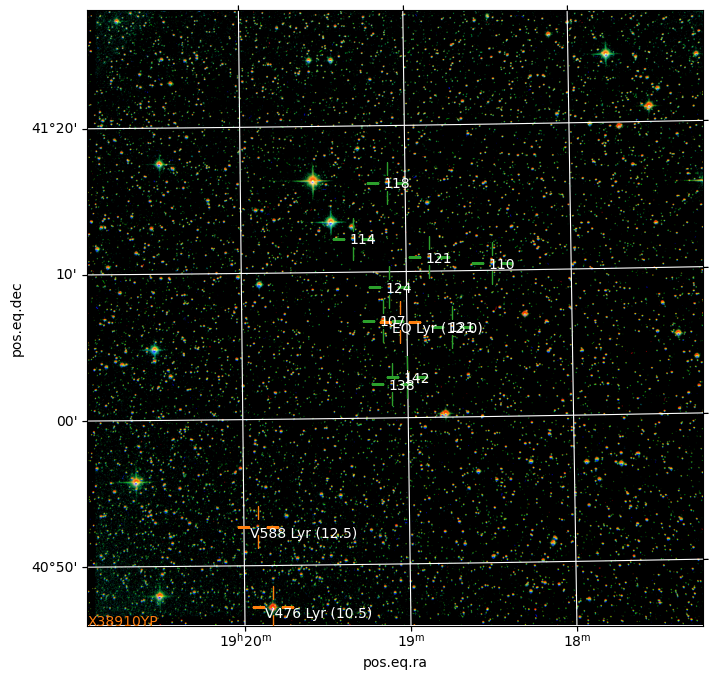

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

J422670:R771142 (DQ Vul) 9 November 2024 22:26:20 UTC
Filters: R V B
Solving for 6CA592A5
solve-field -p -l 30 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 2 /tmp/field-solvershevusa7/tmply0e6nzj.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


ST Vul seq:X38910YS (19)
SW Vul seq:X38910YT (15)
CF Vul seq:X38910YU (18)
DQ Vul seq:X38910YV (14)
V418 Vul seq:X38910YW (4)
V433 Vul seq:X38910YX (14)
V434 Vul seq:X38910YY (14)
V452 Vul seq:X38910YZ (14)
V498 Vul seq:X38910ZA (14)
V571 Vul seq:X38910ZB (11)
NSV_24959 
jid 422670: (DQ Vul)
9 November 2024 22:26:20 UTC
Filters: ('R', 'V', 'B')
Getting 6CA592A5 from cache


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


   GCVS   n_GCVS   RAJ2000     DEJ2000   ... SpType Exists  VarName  Simbad
                                         ...                               
--------- ------ ----------- ----------- ... ------ ------ --------- ------
   ST Vul      x 20 01 13.00 +23 06 34.0 ...               ST    Vul Simbad
   SW Vul      x 20 00 05.21 +22 56 06.6 ...               SW    Vul Simbad
   CF Vul      x 20 00 54.55 +23 05 45.8 ...     Me        CF    Vul Simbad
   DQ Vul      x 20 00 03.01 +22 46 51.7 ...               DQ    Vul Simbad
V0418 Vul        19 59 41.89 +22 33 49.6 ...               V0418 Vul Simbad
V0433 Vul      x 20 00 32.54 +22 40 15.4 ...               V0433 Vul Simbad
V0434 Vul      x 20 00 33.23 +22 43 41.2 ...               V0434 Vul Simbad
V0452 Vul      x 20 00 43.71 +22 42 39.0 ...    G5V        V0452 Vul Simbad
V0498 Vul      * 19 59 51.29 +22 42 32.3 ...               V0498 Vul Simbad
V0571 Vul      * 19 59 29.73 +22 45 13.1 ...               V0571 Vul Simbad
['000-BJP-94

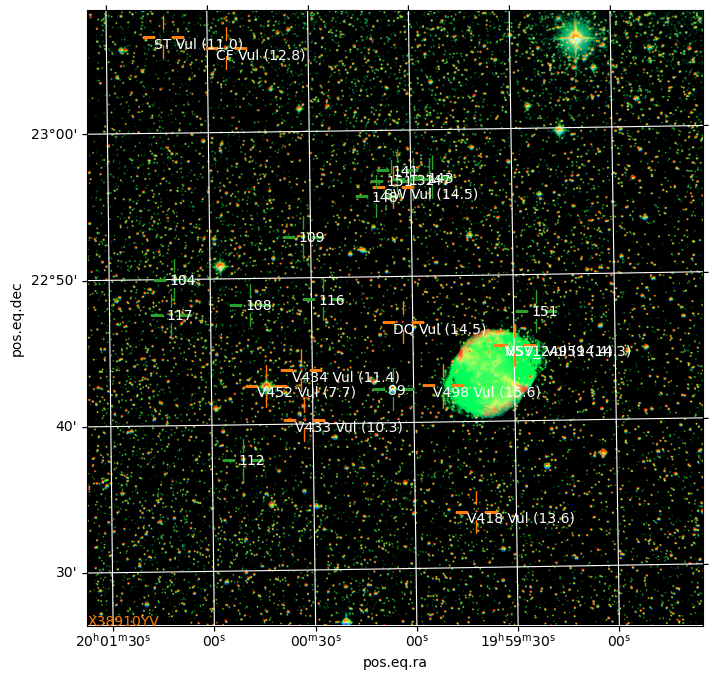

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

J422669:R771141 (DX Vul) 10 November 2024 21:35:39 UTC
Filters: R V B
Solving for 74BFED41
solve-field -p -l 30 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 2 /tmp/field-solver1p6ozp8a/tmpifxyji0f.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X38910ZD (13)
jid 422669: (DX Vul)
10 November 2024 21:35:39 UTC
Filters: ('R', 'V', 'B')
Getting 74BFED41 from cache


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


 GCVS  n_GCVS   RAJ2000     DEJ2000   VarType ... SpType Exists  VarName  Simbad
                                              ...                               
------ ------ ----------- ----------- ------- ... ------ ------ --------- ------
DX Vul      x 20 46 23.05 +25 49 05.5       M ...               DX    Vul Simbad
['000-BKP-901', '103', '20:45:38.34', 311.40975952, '25:52:16.1', 25.87113953, '11.100 (0.063)', '10.281 (0.009)', '0.819 (0.064)', '—']
['000-BLR-840', '109', '20:46:29.36', 311.62234497, '25:38:39.7', 25.6443615, '11.841 (0.023)', '10.908 (0.016)', '0.933 (0.028)', '10.420 (0.022)']
['000-BLR-841', '111', '20:47:06.89', 311.77871704, '25:36:46.2', 25.61283302, '12.518 (0.031)', '11.146 (0.022)', '1.372 (0.038)', '10.519 (0.023)']
['000-BLR-842', '116', '20:47:03.45', 311.76437378, '25:52:29.2', 25.87477684, '12.878 (0.017)', '11.641 (0.011)', '1.237 (0.020)', '11.041 (0.018)']
['000-BKP-903', '118', '20:46:43.01', 311.67919922, '25:44:51.2', 25.74755478, '12.828 (0.

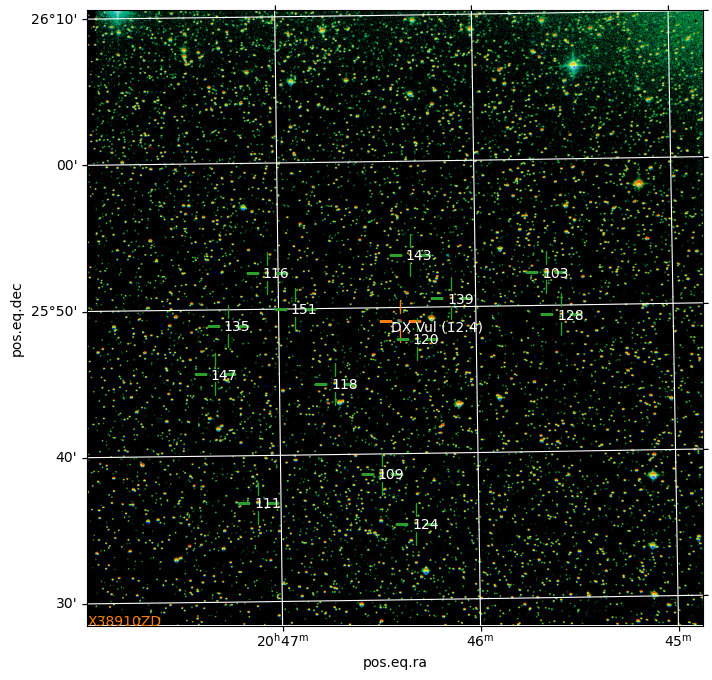

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

J422667:R771139 (V686 Cyg) 10 November 2024 20:48:59 UTC
Filters: R V B
Solving for B1955543
solve-field -p -l 30 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 2 /tmp/field-solverspsrffo2/tmpsgdgdf6w.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X38910ZE (8)
V994 Cyg seq:X38910ZF (9)
V1285 Cyg seq:X38910ZG (5)
V1288 Cyg seq:X38910ZH (14)
V1993 Cyg seq:X38910ZI (9)
NSV_12402 
jid 422667: (V686 Cyg)
10 November 2024 20:48:59 UTC
Filters: ('R', 'V', 'B')
Getting B1955543 from cache
   GCVS   n_GCVS   RAJ2000     DEJ2000   ... SpType Exists  VarName  Simbad
                                         ...                               
--------- ------ ----------- ----------- ... ------ ------ --------- ------
V0686 Cyg      x 19 47 01.13 +35 49 47.5 ...               V0686 Cyg Simbad
V0994 Cyg      x 19 49 09.98 +35 41 21.5 ...               V0994 Cyg Simbad
V1285 Cyg      * 19 44 49.53 +35 59 34.9 ...               V1285 Cyg Simbad
V1288 Cyg      x 19 46 01.30 +36 05 43.9 ...               V1288 Cyg Simbad
V1993 Cyg        19 47 19.86 +35 46 18.9 ...               V1993 Cyg Simbad


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


['000-BCH-969', '100', '19:47:48.53', 296.95220947, '35:33:26.8', 35.55744553, '11.333 (0.120)', '10.028 (0.074)', '1.305 (0.141)', '—']
['000-BCH-980', '103', '19:47:58.69', 296.99453735, '35:51:55.7', 35.86547089, '11.528 (0.122)', '10.321 (0.072)', '1.207 (0.142)', '—']
['000-BCH-912', '112', '19:47:04.66', 296.76940918, '35:48:51.9', 35.81441879, '11.506 (0.125)', '11.199 (0.072)', '0.307 (0.144)', '—']
['000-BCH-889', '114', '19:46:47.25', 296.6968689, '35:47:43.9', 35.79552841, '11.746 (0.170)', '11.427 (0.070)', '0.319 (0.184)', '—']
['000-BCH-930', '117', '19:47:14.39', 296.80996704, '35:48:48.6', 35.81349945, '—', '11.687 (0.083)', '—', '—']
['000-BCH-927', '118', '19:47:13.08', 296.80450439, '35:57:13.4', 35.95372009, '13.509 (0.359)', '11.828 (0.088)', '1.681 (0.370)', '—']
['000-BCH-915', '126', '19:47:06.73', 296.77804565, '35:55:22.7', 35.92297363, '—', '12.568 (0.126)', '—', '—']
['000-BCH-920', '136', '19:47:09.83', 296.79095459, '35:53:32.1', 35.89225006, '—', '13.582 

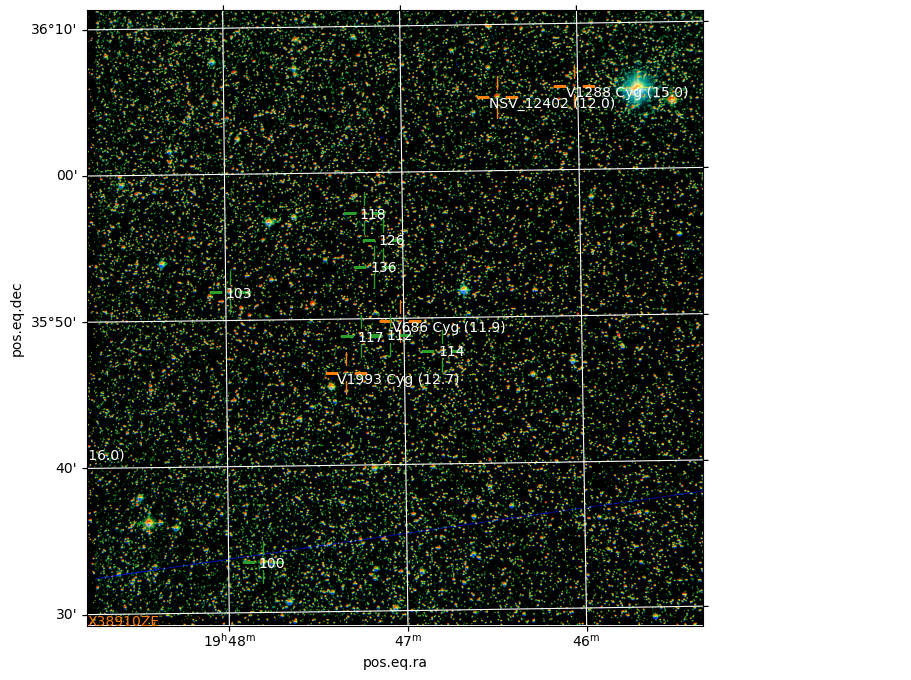

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
#| login
for r in complete[:5]:
    j = OSO.get_request(int(r['id']))
    o = OSO.get_job(int(j['jid']))
    f = OSO.get_obs(o, verbose=True)

    analyse_job(o['jid'], reprocess=True)
    
    plt.figure(figsize=(8,8))
    process_job(o['jid'], reprocess=True, cls=False)
    plt.show()

In [ ]:
# for jid in VSdb['BI Her']['jobs']:
#     if jid in problematic:
#         print(f'{jid} problematic')
#         continue
#     analyse_job(jid, reprocess=True)
#     plt.figure(figsize=(8,8))
#     process_job(jid, reprocess=True, cls=False)
#     plt.show()

In [ ]:
#| login

userjobs = ((int(OSO.get_request(int(j['id']))['jid']), int(j['id'])) for j in complete[:3])
for n, (jid, rid) in enumerate(userjobs):
    if jid in (problematic | done):
        continue
    print(f"{n}:R{rid}:J{jid}")
    try :
        if analyse_job(jid, rid, True):
            done |= {jid}
    except ConnectionError:
        print('Unable to finish')

0:R771144:J422672
J422672:R771144 (LX Cyg) 11 November 2024 00:25:33 UTC
Filters: R V B
Getting EEAD1B8F from cache
LV Cyg seq:X38910YH (41)
LX Cyg seq:X38910YI (44)
LY Cyg seq:X38910YJ (40)
V681 Cyg seq:X38910YK (32)
V682 Cyg seq:X38910YL (13)
V2173 Cyg seq:X38910YM (9)
V2657 Cyg seq:X38910YN (17)


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NSV_13959 
NSV_25782 
1:R771143:J422671
J422671:R771143 (EQ Lyr) 10 November 2024 20:24:07 UTC
Filters: R V B
Getting 3371DF4E from cache


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X38910YP (9)
V476 Lyr seq:X38910YQ (3)
V588 Lyr seq:X38910YR (8)
2:R771142:J422670
J422670:R771142 (DQ Vul) 9 November 2024 22:26:20 UTC
Filters: R V B
Getting 6CA592A5 from cache
ST Vul seq:X38910YS (19)
SW Vul seq:X38910YT (15)
CF Vul seq:X38910YU (18)
DQ Vul seq:X38910YV (14)
V418 Vul seq:X38910YW (4)
V433 Vul seq:X38910YX (14)
V434 Vul seq:X38910YY (14)


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V452 Vul seq:X38910YZ (14)
V498 Vul seq:X38910ZA (14)
V571 Vul seq:X38910ZB (11)
NSV_24959 
